## 라이브러리 임포트

In [1]:
# pip install torchvision==0.11.1

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
import random
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
torch.cuda.empty_cache()

In [3]:
train_path = '/opt/ml/input/data/train'
train_image_dir_path = os.path.join(train_path, 'images')

In [4]:
def seed_everything(seed):
    """
    동일한 조건으로 학습을 할 때, 동일한 결과를 얻기 위해 seed를 고정시킵니다.
    
    Args:
        seed: seed 정수값
    """
    torch.manual_seed(seed) # pytorch의 random seed 고정
    torch.cuda.manual_seed(seed) # GPU 에서 사용하는 난수 생성 시드 고정
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True # CuDNN 부분고정
    torch.backends.cudnn.benchmark = False # CuDNN 부분고정
    np.random.seed(seed) # Numpy 부분
    random.seed(seed) # transforms에서 random 라이브러리를 사용하기 때문에 random 라이브러리를 불러서 고정

seed_everything(42)

## dataset 생성

In [5]:
def search(dirname, result):  # 하위목록의 모든 파일을 찾는 함수
    try:
        filenames = os.listdir(dirname)
        for filename in filenames:
            if filename[0] == '.':  # .으로 시작하는 파일명 거름
                continue
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search(full_filename, result)
            else:
                ext = os.path.splitext(full_filename)[-1]  # 확장자 체크
                if ext:
                    result.append(full_filename)
    except PermissionError:
        pass

In [6]:
all_path = []
search(train_image_dir_path, all_path)

train 데이터의 디렉토리는 2700개로 각각의 7개의 이미지 파일을 곱한 갯수가 나옵니다.

In [7]:
len(all_path) # 2700*7

18900

In [8]:
all_path[:10]

['/opt/ml/input/data/train/images/003554_female_Asian_59/mask3.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/mask5.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/mask4.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/mask1.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/normal.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/mask2.jpg',
 '/opt/ml/input/data/train/images/003845_female_Asian_56/mask3.jpg',
 '/opt/ml/input/data/train/images/003845_female_Asian_56/mask5.jpg',
 '/opt/ml/input/data/train/images/003845_female_Asian_56/incorrect_mask.jpg']

파일 확장자는 jpg, png, jpeg로 3종류가 있습니다.

In [9]:
exts = []
for i in all_path:
    ext = os.path.splitext(i)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts)  # jpg, png, jpeg

['.jpg', '.png', '.jpeg']


In [10]:
all_path = sorted(all_path)
all_path[:10]

['/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask1.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask2.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask3.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask4.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask5.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/normal.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask1.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask2.jpg']

라벨링 하는 함수입니다. 조건에 따라 숫자로 라벨을 부여합니다.

In [11]:
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12
    
    if gender == 'female':
        label += 3
    
    if 30 <= age < 60:
        label += 1
    elif age >= 60:
        label += 2
    
    return label

path, label을 컬럼으로 갖는 dataframe을 생성해줍니다.

In [12]:
train_df = pd.DataFrame(all_path, columns = ['path'])

train_df['label'] = train_df['path'].map(lambda x : labeling(x))
train_df

,path,label
0,/opt/ml/input/data/train/images/000001_female_...,10
1,/opt/ml/input/data/train/images/000001_female_...,4
2,/opt/ml/input/data/train/images/000001_female_...,4
3,/opt/ml/input/data/train/images/000001_female_...,4
4,/opt/ml/input/data/train/images/000001_female_...,4
...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0
18896,/opt/ml/input/data/train/images/006959_male_As...,0
18897,/opt/ml/input/data/train/images/006959_male_As...,0
18898,/opt/ml/input/data/train/images/006959_male_As...,0


In [13]:
# train_df.to_csv('./train_path_label.csv', index=False, encoding='utf-8')
# train_df = pd.read_csv('./train_path_label.csv', encoding='utf-8')

dataset을 상속받아 만든 CustomDataset입니다.
transform은 size를 [512, 284]로 변형하고, Tensor로 만들고, 정규화해줍니다.

In [14]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.X = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform
    
    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.X)

In [15]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
])

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


train, valid 나누는 파트입니다.
label의 비율을 유지하면서 나눴습니다.

In [16]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_df, test_size=0.2,
                               shuffle=True, stratify=train_df['label'],
                               random_state=42)

In [17]:
train.shape, valid.shape

((15120, 2), (3780, 2))

In [18]:
BATCH_SIZE = 128
num_workers=3

In [19]:
train_dataset = CustomDataset(train, transform)
train_dataloader = DataLoader(train_dataset,
                             batch_size = BATCH_SIZE,
                             num_workers=num_workers,
                             drop_last=True,
                             shuffle=True)

In [20]:
valid_dataset = CustomDataset(valid, transform)
valid_dataloader = DataLoader(valid_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=num_workers,
                             drop_last=True,
                             shuffle=True)

dataloader는 [batchsize, channel, height, wide]를 출력해줍니다.

In [21]:
next(iter(train_dataloader))[0].shape

torch.Size([128, 3, 512, 384])

## 모델

이 모델의 마지막 fc층만 저희 과제인 18개의 class로 변경해줍니다.

In [22]:
# !pip3 install ipywidgets

In [23]:
# pip install --upgrade jupyter_client

In [24]:
import torchvision.models as models
# resnet18 = models.resnet18(pretrained=True)
# model = models.vgg16(pretrained=True)
# densenet = models.densenet161(pretrained=True)
# model = models.inception_v3(pretrained=True)
# model = models.googlenet(pretrained=True)
# model = models.mobilenet_v2(pretrained=True)
# model = models.mobilenet_v3_large(pretrained=True)
# model = models.resnext50_32x4d(pretrained=True)
# wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
# model = models.mnasnet1_0(pretrained=True)
# model = models.efficientnet_b0(pretrained=True)
# efficientnet_b1 = models.efficientnet_b1(pretrained=True)
# efficientnet_b2 = models.efficientnet_b2(pretrained=True)
# efficientnet_b3 = models.efficientnet_b3(pretrained=True)
# model = models.efficientnet_b4(pretrained=True)
# efficientnet_b5 = models.efficientnet_b5(pretrained=True)
# efficientnet_b6 = models.efficientnet_b6(pretrained=True)
model = models.efficientnet_b7(pretrained=True)
# regnet_y_400mf = models.regnet_y_400mf(pretrained=True)
# regnet_y_800mf = models.regnet_y_800mf(pretrained=True)
# regnet_y_1_6gf = models.regnet_y_1_6gf(pretrained=True)
# regnet_y_3_2gf = models.regnet_y_3_2gf(pretrained=True)
# regnet_y_8gf = models.regnet_y_8gf(pretrained=True)
# regnet_y_16gf = models.regnet_y_16gf(pretrained=True)
# regnet_y_32gf = models.regnet_y_32gf(pretrained=True)
# regnet_x_400mf = models.regnet_x_400mf(pretrained=True)
# regnet_x_800mf = models.regnet_x_800mf(pretrained=True)
# regnet_x_1_6gf = models.regnet_x_1_6gf(pretrained=True)
# regnet_x_3_2gf = models.regnet_x_3_2gf(pretrained=True)
# regnet_x_8gf = models.regnet_x_8gf(pretrained=True)
# regnet_x_16gf = models.regnet_x_16gf(pretrained=True)
# regnet_x_32gf = models.regnet_x_32gf(pretrained=True)

In [25]:
layer_list = list(model.children())
layer_num = len(layer_list)
in_features = layer_list[-1][-1].in_features

In [26]:
in_features

2560

In [27]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [28]:
ct = 0
for child in model.children():
    ct += 1
    if ct < layer_num:
        for param in child.parameters():
            param.requires_grad = False

In [29]:
import math

OUTPUT_CLASS_NUM = 18
model.classifier[1] = torch.nn.Linear(in_features = in_features, out_features = OUTPUT_CLASS_NUM, bias=True)  # output 18개로

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

아래의 대부분의 코드가 부스트캠프에서 학습자료나 과제로 제공받았던 코드를 거의 그대로 사용했습니다. 설명도 주석으로 잘 달려 있어서 그대로 가져왔습니다.
<br/><br/>
epoch는 5, lr은 0.0001로 주었습니다.

In [31]:
model.to(device)

LEARNING_RATE = 0.0001  # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 20  # 학습 때 mnist train 데이터셋을 얼마나 많이 학습할 지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss()  # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # weight업데이트를 위한 optimizer를 Adam으로 사용

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

In [32]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            model.train()  # 네트워크 모델을 train 모드로 두어 gradient를 계산하고, 여러 sub module(배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            model.eval()  # 네트워크 모델을 eval 모드로 두어 여러 sub module들이 eval mode로 작동할 수 있게 함
        
        for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # parameter gradient 업데이터 전 초기화함
            
            with torch.set_grad_enabled(phase == "train"):  # train 모드 땐 gradient계산, 아닐 땐 gradient계산 안함으로써 연산량 줄임
                logits = model(images)
                _, preds = torch.max(logits, 1)  # 모델에서 linear하게 나오는 예측값 리스트에서 최대 output index를 찾아 예측 레이블로 변경함
                loss = loss_fn(logits, labels)
                
                if phase == "train":
                    loss.backward()  # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step()  # 계산된 gradient를 가지고 모델 업데이트
            
            running_loss += loss.item() * images.size(0) # 한 batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data) # 한 batch에서의 acc 값 저장
            
        # 한 epoch이 모두 종료되었을 때
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        
        print(f"현재 epoch-{epoch}의 {phase}-데이터셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
        if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best acc 계산
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때 best loss 계산
            best_test_loss = epoch_loss

print("학습 종료!")
print(f"best acc : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")


현재 epoch-0의 train-데이터셋에서 평균 Loss : 2.518, 평균 Accuracy : 0.374



현재 epoch-0의 test-데이터셋에서 평균 Loss : 2.381, 평균 Accuracy : 0.470



현재 epoch-1의 train-데이터셋에서 평균 Loss : 2.047, 평균 Accuracy : 0.609



현재 epoch-1의 test-데이터셋에서 평균 Loss : 1.688, 평균 Accuracy : 0.661



현재 epoch-2의 train-데이터셋에서 평균 Loss : 1.732, 평균 Accuracy : 0.669



현재 epoch-2의 test-데이터셋에서 평균 Loss : 1.430, 평균 Accuracy : 0.708



현재 epoch-3의 train-데이터셋에서 평균 Loss : 1.510, 평균 Accuracy : 0.698



현재 epoch-3의 test-데이터셋에서 평균 Loss : 1.276, 평균 Accuracy : 0.732



현재 epoch-4의 train-데이터셋에서 평균 Loss : 1.348, 평균 Accuracy : 0.724



현재 epoch-4의 test-데이터셋에서 평균 Loss : 1.151, 평균 Accuracy : 0.746



현재 epoch-5의 train-데이터셋에서 평균 Loss : 1.226, 평균 Accuracy : 0.738



현재 epoch-5의 test-데이터셋에서 평균 Loss : 1.054, 평균 Accuracy : 0.759



현재 epoch-6의 train-데이터셋에서 평균 Loss : 1.127, 평균 Accuracy : 0.752



현재 epoch-6의 test-데이터셋에서 평균 Loss : 0.977, 평균 Accuracy : 0.768



현재 epoch-7의 train-데이터셋에서 평균 Loss : 1.049, 평균 Accuracy : 0.765



현재 epoch-7의 test-데이터셋에서 평균 Loss : 0.914, 평균 Accuracy : 0.779



현재 epoch-8의 train-데이터셋에서 평균 Loss : 0.989, 평균 Accuracy : 0.773



현재 epoch-8의 test-데이터셋에서 평균 Loss : 0.862, 평균 Accuracy : 0.785



현재 epoch-9의 train-데이터셋에서 평균 Loss : 0.936, 평균 Accuracy : 0.782



현재 epoch-9의 test-데이터셋에서 평균 Loss : 0.820, 평균 Accuracy : 0.790



현재 epoch-10의 train-데이터셋에서 평균 Loss : 0.890, 평균 Accuracy : 0.790



현재 epoch-10의 test-데이터셋에서 평균 Loss : 0.781, 평균 Accuracy : 0.793



현재 epoch-11의 train-데이터셋에서 평균 Loss : 0.851, 평균 Accuracy : 0.798



현재 epoch-11의 test-데이터셋에서 평균 Loss : 0.752, 평균 Accuracy : 0.796



현재 epoch-12의 train-데이터셋에서 평균 Loss : 0.813, 평균 Accuracy : 0.802



현재 epoch-12의 test-데이터셋에서 평균 Loss : 0.720, 평균 Accuracy : 0.802



현재 epoch-13의 train-데이터셋에서 평균 Loss : 0.785, 평균 Accuracy : 0.804



현재 epoch-13의 test-데이터셋에서 평균 Loss : 0.699, 평균 Accuracy : 0.806



현재 epoch-14의 train-데이터셋에서 평균 Loss : 0.761, 평균 Accuracy : 0.807



현재 epoch-14의 test-데이터셋에서 평균 Loss : 0.680, 평균 Accuracy : 0.808



현재 epoch-15의 train-데이터셋에서 평균 Loss : 0.739, 평균 Accuracy : 0.815



현재 epoch-15의 test-데이터셋에서 평균 Loss : 0.659, 평균 Accuracy : 0.809



현재 epoch-16의 train-데이터셋에서 평균 Loss : 0.718, 평균 Accuracy : 0.815



현재 epoch-16의 test-데이터셋에서 평균 Loss : 0.643, 평균 Accuracy : 0.811



현재 epoch-17의 train-데이터셋에서 평균 Loss : 0.699, 평균 Accuracy : 0.815



현재 epoch-17의 test-데이터셋에서 평균 Loss : 0.630, 평균 Accuracy : 0.812



현재 epoch-18의 train-데이터셋에서 평균 Loss : 0.677, 평균 Accuracy : 0.820



현재 epoch-18의 test-데이터셋에서 평균 Loss : 0.614, 평균 Accuracy : 0.815



현재 epoch-19의 train-데이터셋에서 평균 Loss : 0.661, 평균 Accuracy : 0.824



현재 epoch-19의 test-데이터셋에서 평균 Loss : 0.602, 평균 Accuracy : 0.817
학습 종료!
best acc : 0.8166666626930237, 최고 낮은 loss : 0.6015917742693866


loss가 계속 떨어지고 있기 때문에 epoch를 늘려서 학습해도 좋을 것 같습니다.
<br/><br/>
valid data 기준 99프로의 정확도를 보여주지만, 실제 test 데이터는 train이나 valid와 많이 다를 것으로 예상됩니다.

In [33]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0, 0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1)  # 행으로 비교
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_acc = (n_correct/n_total)
        #model_train()
    return val_acc

In [34]:
func_eval(model, valid_dataloader, device)

0.8302801724137931

실제 정답과 pred를 비교하고자 path, pred, target을 dataframe으로 만들었습니다.

In [35]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)
            
            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [36]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle=False)

check_eval_df = check_eval(valid, valid_testing_dataloader, model, device)
check_eval_df

,path,pred,target
0,/opt/ml/input/data/train/images/001151_male_As...,4,0
1,/opt/ml/input/data/train/images/001836_female_...,3,3
2,/opt/ml/input/data/train/images/004079_male_As...,4,1
3,/opt/ml/input/data/train/images/003763_female_...,4,4
4,/opt/ml/input/data/train/images/006502_male_As...,0,0
...,...,...,...
3775,/opt/ml/input/data/train/images/001718_male_As...,0,1
3776,/opt/ml/input/data/train/images/003889_female_...,3,4
3777,/opt/ml/input/data/train/images/003943_male_As...,1,1
3778,/opt/ml/input/data/train/images/001495-1_male_...,6,6


잘못 예측한 데이터만 모아봤습니다.

In [37]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/001151_male_As...,4,0
1,/opt/ml/input/data/train/images/004079_male_As...,4,1
2,/opt/ml/input/data/train/images/004230_female_...,10,11
3,/opt/ml/input/data/train/images/001090_male_As...,0,1
4,/opt/ml/input/data/train/images/006728_male_As...,13,12
...,...,...,...
631,/opt/ml/input/data/train/images/003738_female_...,10,4
632,/opt/ml/input/data/train/images/001635_male_As...,12,13
633,/opt/ml/input/data/train/images/004477_female_...,10,11
634,/opt/ml/input/data/train/images/001718_male_As...,0,1


틀린 데이터들을 살펴보기 위해 이미지와 같이 출력을 해보겠습니다.

In [38]:
# def draw_(df):
#     plt.figure(figsize=(17,32))
#     row = 7
#     for i in range(df.shape[0]):
#         plt.subplot(row+1, df.shape[0]//row, i+1)
#         plt.imshow(Image.open(df['path'][i]))
#         plt.title(f"target:{df['target'][i]}, pred:{df['pred'][i]}", size=20)
#         plt.axis("off")
#     plt.tight_layout()
#     plt.show()

In [39]:
# draw_(wrong_df)

* 대체로 조금씩 어리게 + incorrect를 wear으로 잘못 예측
    * 특히 노년층의 데이터가 적어서 그런지 노년층을 중장년층으로 인식하는 경우가 다수
    * 특히 마스크 안쓴 데이터에서 중장년층 여성을 청년 여성으로 분류하는 경우도 꽤 있음
* 남성의 머리카락이 조금만 길어도 여성으로 예측 -> 장발 남성 데이터를 데이터 어그멘테이션 해볼까?
* 11번째 데이터 잘못 레이블링됨(5227번째 데이터. 수정 완료.)

## f1 score 측정

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
f1_score(check_eval_df['target'], check_eval_df['pred'], average='macro')

0.6334649701141575

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.85      0.95      0.90       554
           1       0.78      0.79      0.79       409
           2       0.71      0.35      0.47        83
           3       0.90      0.92      0.91       727
           4       0.82      0.86      0.84       818
           5       0.76      0.38      0.50       109
           6       0.80      0.88      0.84       111
           7       0.71      0.66      0.68        82
           8       0.00      0.00      0.00        16
           9       0.87      0.84      0.86       145
          10       0.75      0.73      0.74       164
          11       1.00      0.05      0.09        22
          12       0.85      0.94      0.89       111
          13       0.77      0.80      0.79        82
          14       1.00      0.06      0.12        16
          15       0.93      0.89      0.91       145
          16       0.78      0.93      0.85       164
          17       1.00    

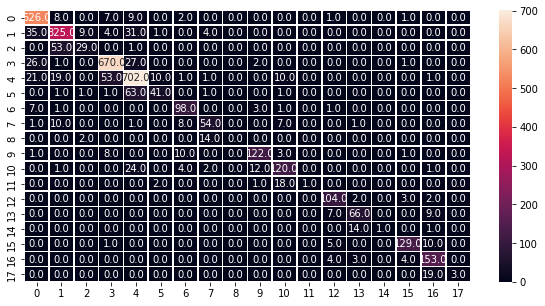

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

def report():
    y_test, y_pred = check_eval_df['target'], check_eval_df['pred']
    print(classification_report(y_test, y_pred))
    ax = plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=0.5, fmt='.1f', annot=True)

report()

In [42]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [43]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = model.to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submit_dir = '/opt/ml/submit'
submission.to_csv(os.path.join(submit_dir, 'efficientnet_b7-epoch20.csv'), index=False)
print('test inference is done!')

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


test inference is done!


In [44]:
# epoch 10
# f1score:0.6000 / acc:82.0000
# f1score:0.5178 / acc:66.6667

# epoch 20
# f1score:0.6300 / acc:83.0000
# 제출 안함

* 가장 실제 제출 결과와 비슷!